- Summarize the class distribution, the lengths of time series, and basic descriptive statistics

- Report any characteristics that could be used to deduce which class a time series belongs to

- Visualize ECG time series of the individual classes, and explain the differences between classes by utilizing the collected statistics

- Construct a validation split from your training data that reflects the characteristics of the full training data. In the report, justify your selection.

In [1]:
from pathlib import Path
BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR / "data" # Directory to store data files
DATA_DIR.mkdir(exist_ok=True)


In [2]:
assert (DATA_DIR / "y_train.csv").exists(), "Please add the unzipped y_train.csv file to the data directory."
assert (DATA_DIR / "X_train.bin").exists(), "Please add the unzipped X_train.bin file to the data directory."
assert (DATA_DIR / "X_test.bin").exists(), "Please add the unzipped X_test.bin file to the data directory."

In [3]:
import os
import struct
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

root_path = BASE_DIR
data_path = BASE_DIR / "data" # Directory to store data files
train_data_path = BASE_DIR / "data" / "X_train.bin"
test_data_path = BASE_DIR / "data" / "X_test.bin"
train_label_path = BASE_DIR / "data" / "y_train.csv"

In [4]:
def read_binary(path):
    ragged_array = []
    with open(path, "rb") as r:
        read_binary_from(ragged_array, r)
    return ragged_array

def read_binary_from(ragged_array, r):
    while(True):
        size_bytes = r.read(4)
        if not size_bytes:
            break
        sub_array_size = struct.unpack('i', size_bytes)[0]
        sub_array = list(struct.unpack(f'{sub_array_size}h', r.read(sub_array_size * 2)))
        ragged_array.append(sub_array)

In [5]:
label_dict = {
    0: 'Normal',
    1: 'AF',
    2: 'Other',
    3: 'Noisy'
}

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def summarize_ecg_data(signal_list: list, label_df: pd.DataFrame,):

    assert len(signal_list) == len(label_df), (
        f"Signal list length ({len(signal_list)}) does not match label DataFrame length ({len(label_df)})"
    )
    

    lengths = np.array([len(sig) for sig in signal_list])
    
    stats = pd.Series(lengths).describe().astype(int)

    # sample 5 random signals
    sample_idxs = np.random.choice(len(signal_list), size=5, replace=False)

    sample_df = pd.DataFrame({
        'index': sample_idxs,
        'label': label_df.iloc[sample_idxs, 0].map(label_dict),
        'length': lengths[sample_idxs]
    })
    
    
    print(f"Total signals: {len(signal_list)}")
    print(f"Total labels: {len(label_df)}\n")
    
    print("----- Signal Lengths Summary -----")
    print(stats.to_frame(name='value'), "\n")
    
    print("— Sample Signals —")
    print(sample_df.to_string(index=False), "\n")
    
    # 6) Histogram
    plt.figure(figsize=(8,4))
    plt.hist(lengths, bins=50, edgecolor='k', alpha=0.7)
    plt.title("Distribution of ECG Signal Lengths in Train Set")
    plt.xlabel("Length (samples)")
    plt.ylabel("Count")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

Total signals: 6179
Total labels: 6179

----- Signal Lengths Summary -----
       value
count   6179
mean    9760
std     3292
min     2714
25%     9000
50%     9000
75%     9000
max    18286 

— Sample Signals —
 index  label  length
  3739     AF    9000
  4414 Normal    9930
  5594 Normal    9000
  5043  Other    9000
  4092 Normal    9000 



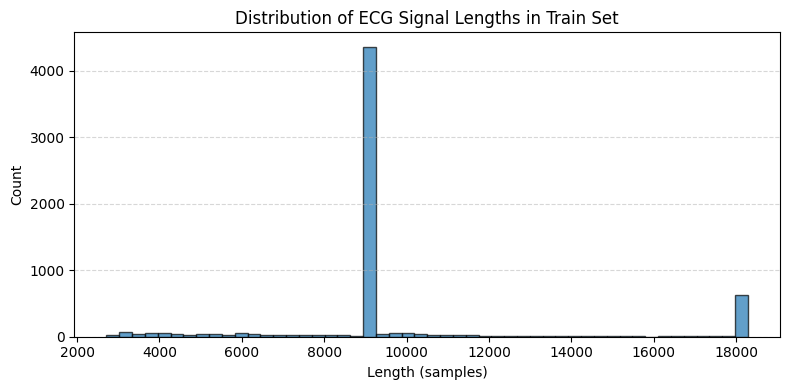

In [7]:
signals = read_binary(train_data_path)
labels  = pd.read_csv(train_label_path, header=None)
summarize_ecg_data(signals, labels)

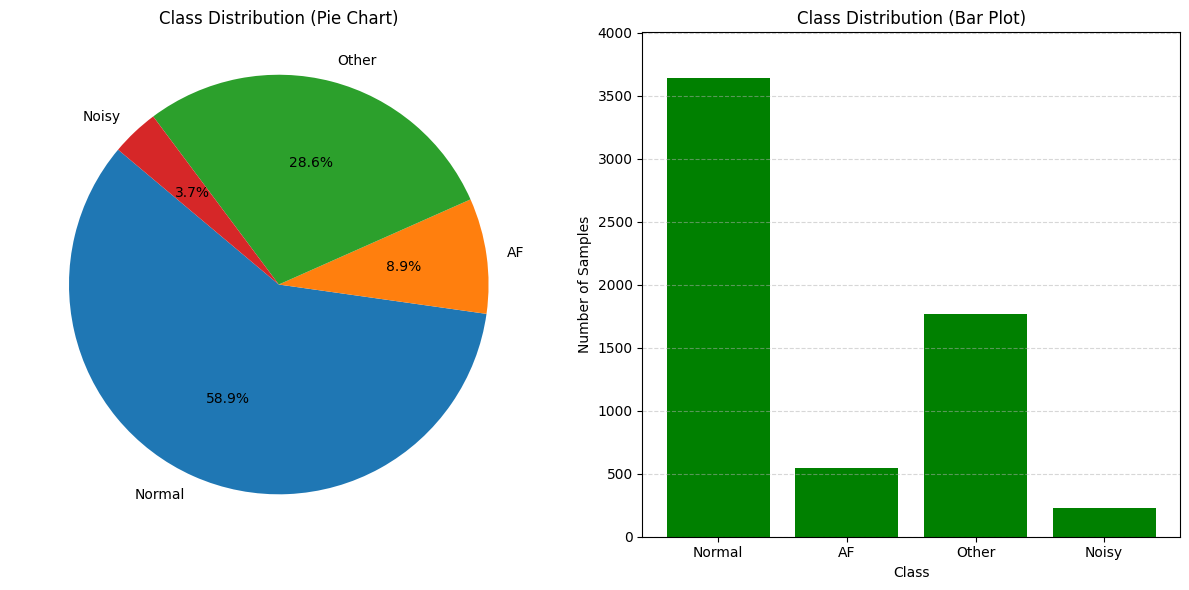

In [8]:
import matplotlib.pyplot as plt


label_counts = {key: 0 for key in label_dict.keys()}
for i in range(len(labels)):
    label = labels.iloc[i, 0] 
    label_counts[label] += 1
    
classes = label_dict.values()
counts = label_counts.values()
total = sum(counts)
percentages = [(count / total) * 100 for count in counts]

# define 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Pie chart
ax1.pie(percentages, labels=classes, autopct='%1.1f%%', startangle=140)
ax1.axis('equal')  
ax1.set_title("Class Distribution (Pie Chart)")
# Bar plot
ax2.bar(classes, counts, color='green')
ax2.set_title("Class Distribution (Bar Plot)")
ax2.set_xlabel("Class")
ax2.set_ylabel("Number of Samples")
ax2.grid(axis='y', linestyle='--', alpha=0.5)
ax2.set_ylim(0, max(counts) * 1.1)


plt.tight_layout()
plt.show()


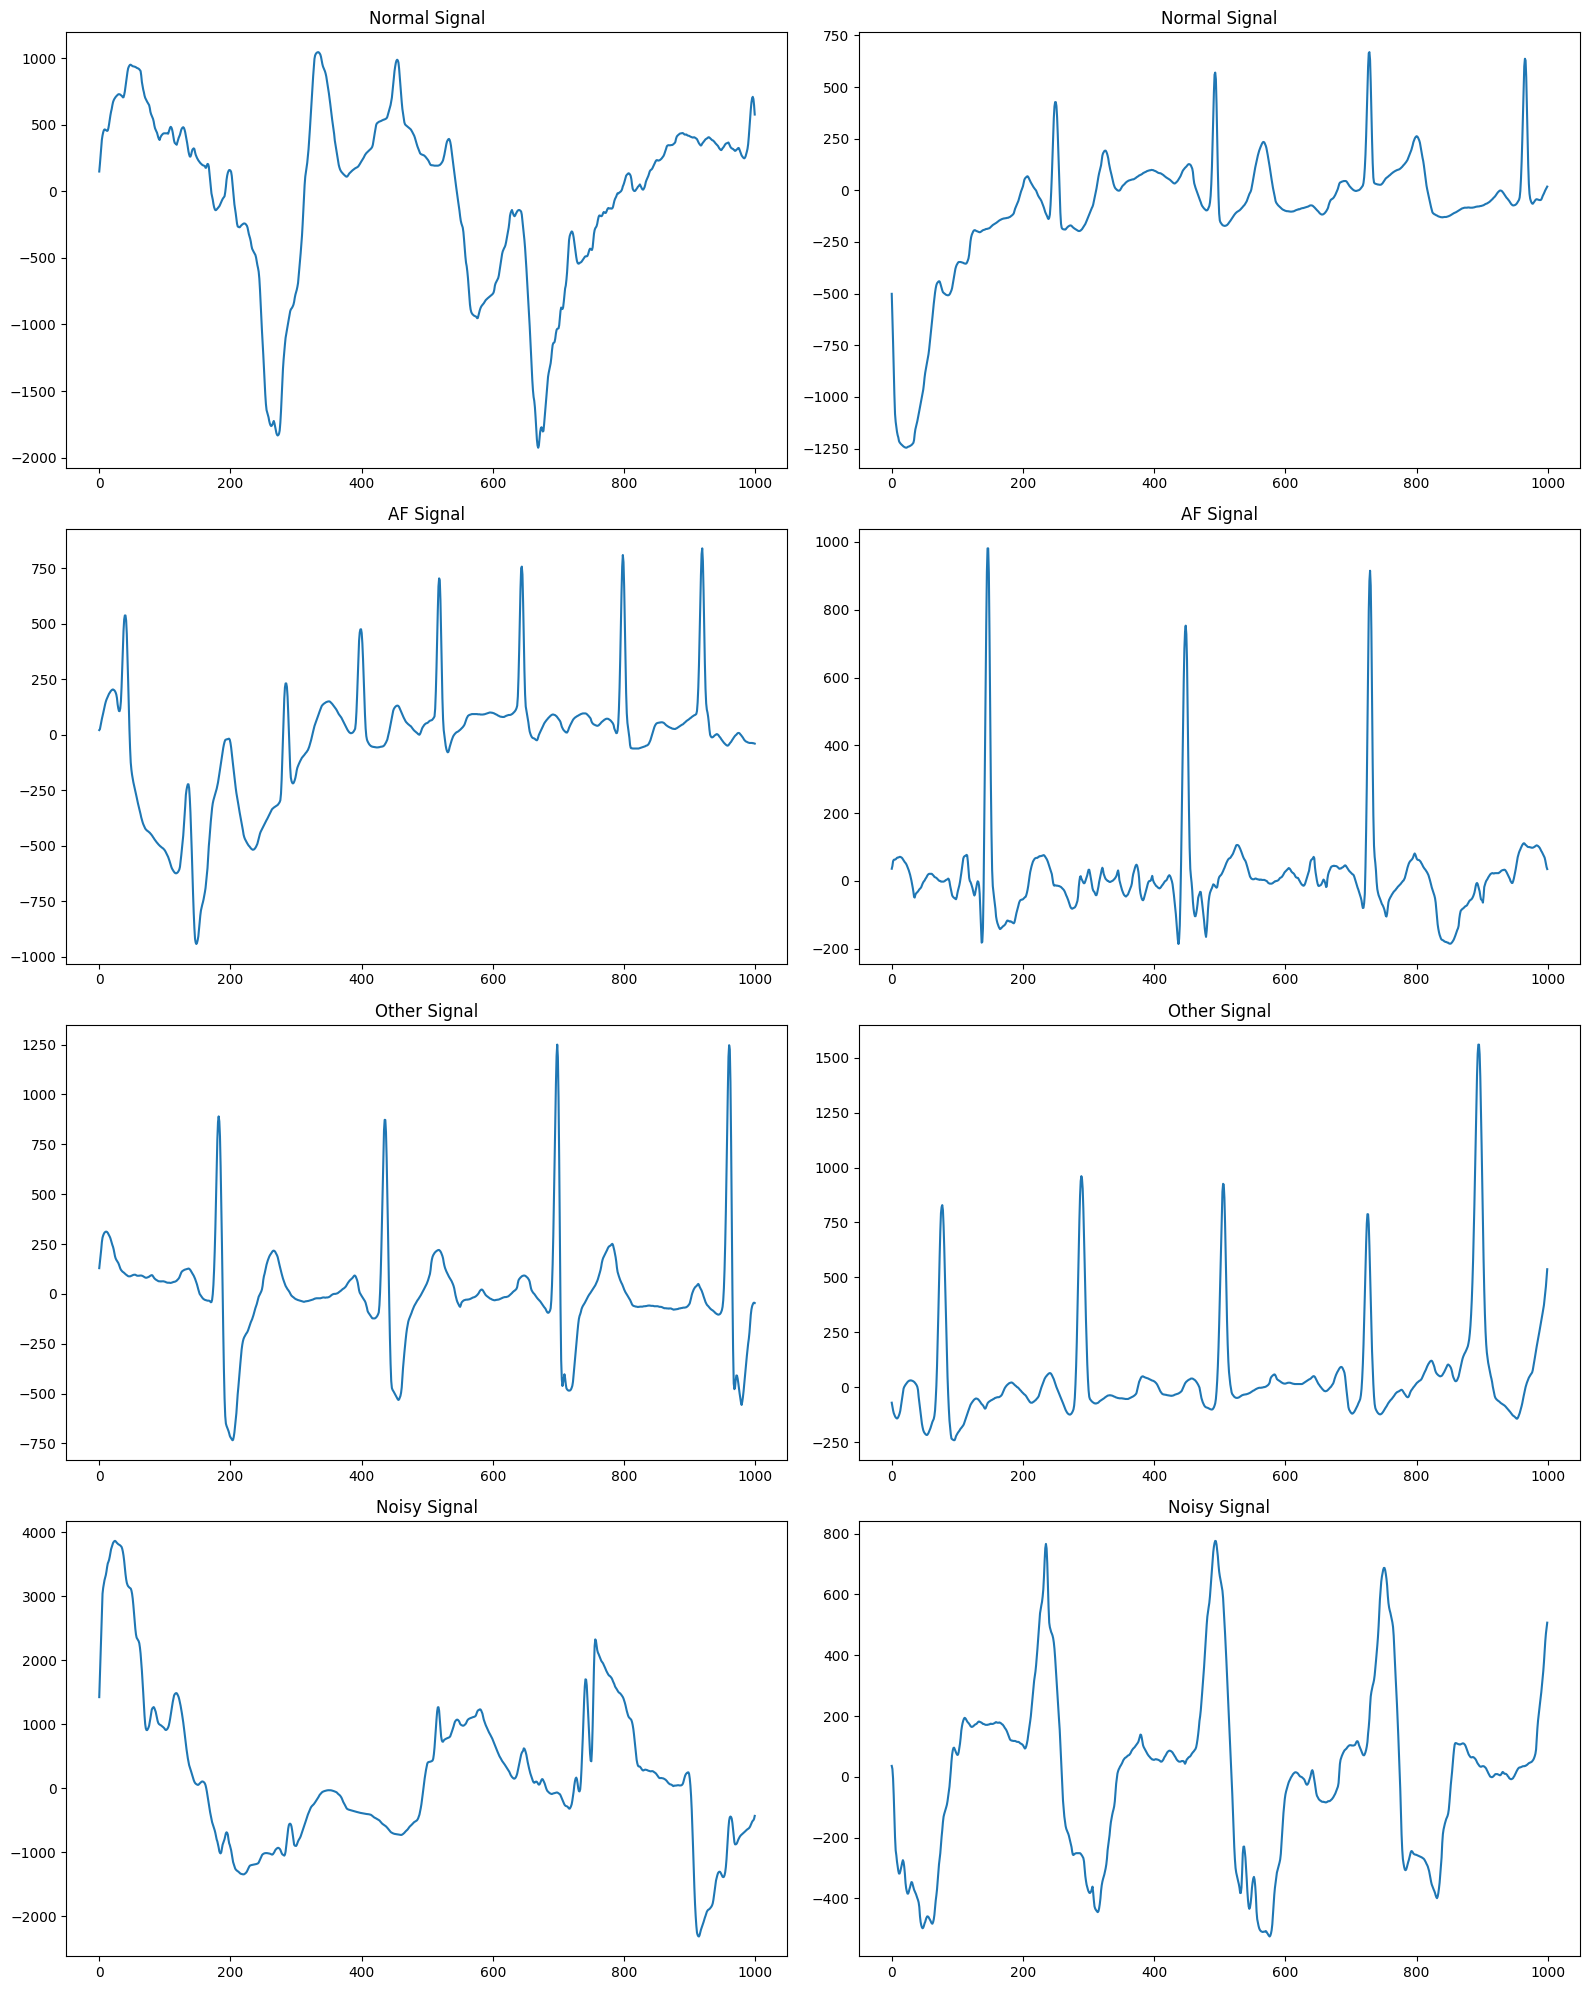

In [9]:
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

for i, klass in enumerate(label_dict.keys()):
    class_signals = [signal for signal, label in zip(signals, labels.iloc[:, 0]) if label == klass]
    # 2 random samples from each class
    random_signals = random.sample(class_signals, 2)
    for j, signal in enumerate(random_signals):
        axes[2*i+j].plot(signal[:1000])
        axes[2*i+j].set_title(f"{label_dict[klass]} Signal")

plt.tight_layout()
plt.show()

In [10]:
ecg_df = pd.DataFrame({
    'length': [len(sig) for sig in signals],
    'label': labels[0],
    'signal': signals

})

ecg_df

,length,label,signal
0,9000,2,"[-217, -246, -294, -344, -363, -371, -377, -37..."
1,18000,2,"[-446, -541, -637, -733, -819, -858, -867, -87..."
2,9000,2,"[-440, -527, -614, -698, -770, -790, -796, -79..."
3,9000,0,"[-1255, -1488, -1745, -2015, -2253, -2374, -23..."
4,9000,0,"[156, 189, 223, 255, 291, 330, 362, 380, 390, ..."
...,...,...,...
6174,9000,0,"[546, 588, 632, 679, 696, 673, 605, 536, 512, ..."
6175,9000,0,"[503, 600, 695, 789, 873, 915, 911, 891, 883, ..."
6176,9000,0,"[-339, -412, -490, -566, -618, -632, -642, -64..."
6177,9000,2,"[271, 469, 690, 862, 932, 875, 707, 456, 177, ..."


In [11]:
stats= ecg_df.groupby('label')['length'].agg([np.mean, np.std, np.min, np.max])
stats = stats.rename(columns={
    'mean': 'Mean Length',
    'std': 'Std Length',
    'amin': 'Min Length',
    'amax': 'Max Length'
})
stats = stats.reset_index()
stats = stats.rename(columns={'label': 'Class'})
stats['Class'] = stats['Class'].map(label_dict)
# .3f format for float values
stats['Std Length'] = stats['Std Length'].map('{:.3f}'.format)
stats['Mean Length'] = stats['Mean Length'].map('{:.3f}'.format)
# add title to the table
new_stats=stats.style.set_caption("Statistics of ECG Signal Lengths by Class")
new_stats


,Class,Mean Length,Std Length,Min Length,Max Length
0,Normal,9662.821,3020.083,2714,18286
1,AF,9510.863,3623.816,2996,18062
2,Other,10366.380,3573.787,2738,18188
3,Noisy,7210.216,2883.541,2808,18000


In [12]:
class_stats = {}
for label, group in ecg_df.groupby('label'):
    all_signals = np.concatenate(group['signal'].values)
    class_stats[label] = {
        'mean_value': np.mean(all_signals),
        'std': np.std(all_signals),
        'min_value': np.min(all_signals),
        'max_value': np.max(all_signals),
    }

# Print the statistics for each class as dataframe
class_stats_df = pd.DataFrame(class_stats).T
class_stats_df = class_stats_df.rename(columns={
    'mean_value': 'Mean Value',
    'std': 'Std',
    'min_value': 'Min Value',
    'max_value': 'Max Value'
})
class_stats_df = class_stats_df.reset_index()
class_stats_df = class_stats_df.rename(columns={'index': 'Class'})
class_stats_df['Class'] = class_stats_df['Class'].map(label_dict)
# .3f format for float values and int format for min and max values
class_stats_df['Min Value'] = class_stats_df['Min Value'].astype(int)
class_stats_df['Max Value'] = class_stats_df['Max Value'].astype(int)
class_stats_df['Std'] = class_stats_df['Std'].map('{:.3f}'.format)
class_stats_df['Mean Value'] = class_stats_df['Mean Value'].map('{:.3f}'.format)
# add title to the table
new_class_stats_df = class_stats_df.style.set_caption("Statistics of ECG Signal Values by Class")
new_class_stats_df


,Class,Mean Value,Std,Min Value,Max Value
0,Normal,7.777,228.918,-10636,8318
1,AF,8.055,201.118,-6323,6342
2,Other,6.635,234.003,-7360,8257
3,Noisy,5.312,502.394,-7030,7440


##### Insights
- Noisy signals are shorter on average, so unusually short segments might indicate noise. But overall, length alone won’t robustly separate classes. They also have a much higher standard deviation, indicating more volatility. This is a very strong cue for identifying noisy signals.

- Signals are for sure not representative enough. Some of "normal" ECG signals are not normal for example. The figure below and the plot of normal signals above are not always similar. 


## Frequency-Domain Analysis: Power Spectral Density (PSD)

To better understand the nature of ECG signals from different classes (Normal, AF, Other, Noisy), we performed a frequency-domain analysis using the **Power Spectral Density (PSD)**.

### Why PSD?

While ECG signals are typically analyzed in the time domain, **frequency analysis reveals hidden patterns** that help distinguish signal types, especially:

- **Noisy signals** often have energy across a broad frequency range.
- **Normal/AF/Other signals** tend to concentrate energy in lower frequency bands.

### Method

We used the **Welch method** to compute PSD:
- Sampling rate = 300 Hz
- Each class: 50 random signals were selected
- Frequencies were limited to the range of **0–50 Hz** (clinically relevant band)

```python
from scipy.signal import welch
f, Pxx = welch(signal, fs=300, nperseg=2048)


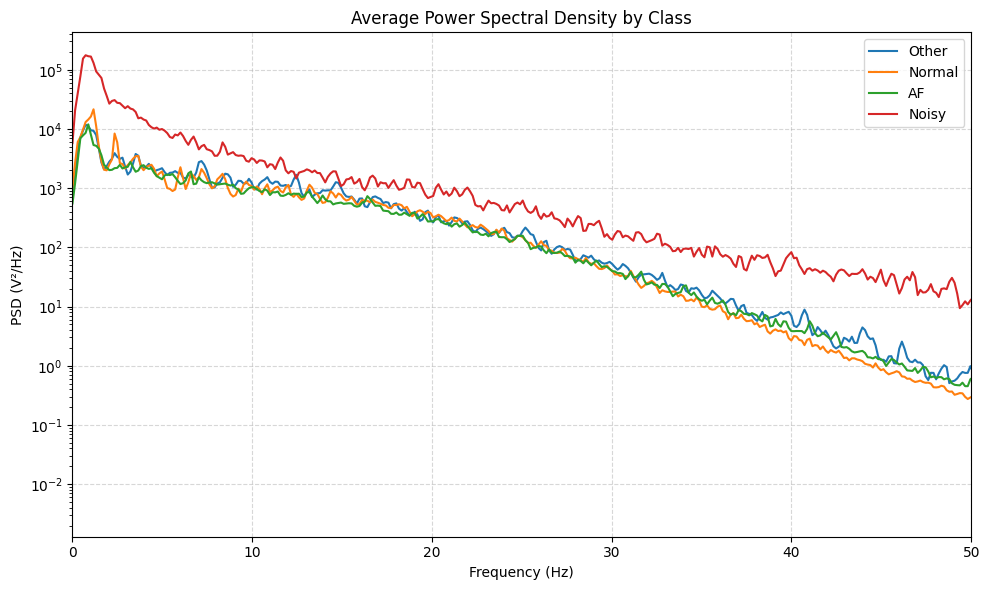

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html


SAMPLING_RATE = 300      # Hz
NFFT = 2048              # FFT length (we can use a smaller value for faster computation)
classes = ecg_df['label'].unique()



freqs, _ = welch(ecg_df['signal'].iloc[0], fs=SAMPLING_RATE, nperseg=NFFT)

# average PSD for each class
psd_by_class = {}
for cls in classes:
    sample_signals = ecg_df[ecg_df['label']==cls]['signal'].sample(n=50, random_state=42)
    
    psd_list = []
    for sig in sample_signals:
        f, Pxx = welch(sig, fs=SAMPLING_RATE, nperseg=NFFT)
        psd_list.append(Pxx)
    psd_by_class[cls] = np.mean(psd_list, axis=0)


plt.figure(figsize=(10,6))
for cls, psd in psd_by_class.items():
    plt.semilogy(freqs, psd, label=cls)
plt.title("Average Power Spectral Density by Class")
# change legend labels to map to label_dict
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (V²/Hz)")
plt.xlim(0, 50)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend([label_dict[int(cls)] for cls in psd_by_class.keys()])
plt.show()


In [14]:
[label_dict[int(cls)] for cls in psd_by_class.keys()]

['Other', 'Normal', 'AF', 'Noisy']

The PSD analysis reveals that noisy ECG signals have significantly higher energy across all frequencies, especially in the high-frequency range (15–50 Hz), clearly separating them from clean signals.

In contrast, Normal, AF, and Other classes show similar spectral patterns with most energy concentrated below 20 Hz.Then,frequency-domain features such as bandpower can help detect noisy signals and may contribute to distinguishing

### Visual Patterns / Rhythm

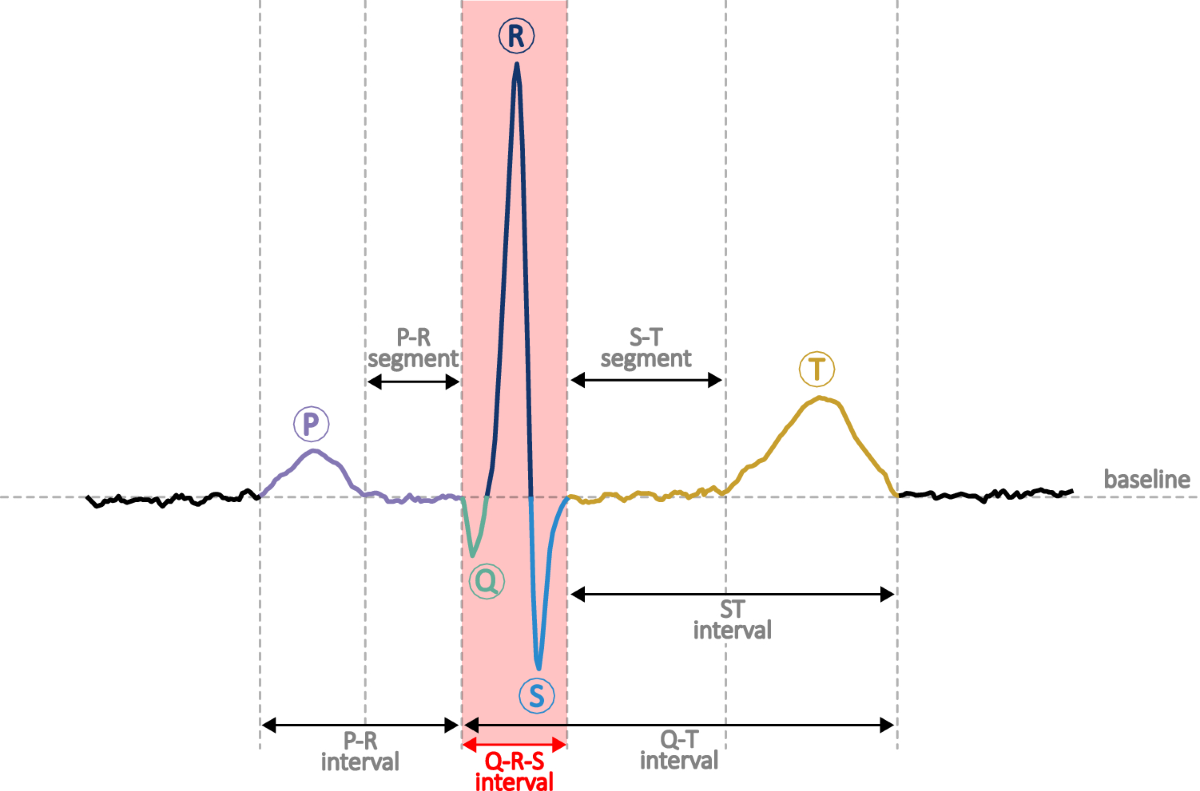


The QRS interval is a distinct part of the ECG waveform that reflects the electrical activity of the ventricles (the main chambers of the heart) as they contract.

The R wave is one of the deflections within the QRS complex. It's the positive (upward) deflection, and it's typically the largest wave in the QRS.

The R peak is simply the highest point of the R wave within the QRS interval.

- Heart Rate Estimate
    -  Count R-peaks, divide by duration in minutes. Get the statistics of this value for each class
- RR Interval Variation
    - Compute the standard deviation of RR intervals over the signal.
   

In [15]:
from scipy.signal import find_peaks # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
from collections import defaultdict # https://docs.python.org/3/library/collections.html#defaultdict-objects

SAMPLING_RATE = 300 # 300 Hz information was given in the task

stats_by_class = defaultdict(list)

for idx, row in ecg_df.iterrows():
    signal = row['signal']
    label = row['label']
    
    # A useful condition for periodic signals can be given with the distance argument.
    # In this case, we can select the positions of QRS complexes within ECG by demanding a distance of at least 150 samples.
    peaks, _ = find_peaks(signal, distance = SAMPLING_RATE * 0.5)
    duration_seconds = len(signal) / SAMPLING_RATE
    heart_rate_bpm = len(peaks) / (duration_seconds / 60)
    
    rr_intervals = np.diff(peaks) / SAMPLING_RATE 
    rr_std_ms = np.std(rr_intervals * 1000) # calculating std in ms for clear values
    
    stats_by_class[label].append((heart_rate_bpm, rr_std_ms))
    
for label in sorted(stats_by_class.keys()):
    data = np.array(stats_by_class[label])
    heart_rates = data[:, 0]
    rr_stds = data[:, 1]

    print(f"\nClass {label_dict[label]}:")
    print(f"  Heart Rate (bpm): mean={heart_rates.mean():.2f}, std={heart_rates.std():.2f}, min={heart_rates.min():.2f}, max={heart_rates.max():.2f}")
    print(f"  RR Std Dev (ms): mean={rr_stds.mean():.2f}, std={rr_stds.std():.2f}, min={rr_stds.min():.2f}, max={rr_stds.max():.2f}")


Class Normal:
  Heart Rate (bpm): mean=78.75, std=8.89, min=60.00, max=106.00
  RR Std Dev (ms): mean=105.06, std=68.17, min=2.40, max=283.32

Class AF:
  Heart Rate (bpm): mean=84.45, std=5.66, min=64.00, max=104.00
  RR Std Dev (ms): mean=142.57, std=33.72, min=19.65, max=265.88

Class Other:
  Heart Rate (bpm): mean=82.88, std=10.58, min=60.00, max=118.00
  RR Std Dev (ms): mean=122.54, std=59.96, min=2.34, max=298.27

Class Noisy:
  Heart Rate (bpm): mean=83.59, std=6.46, min=66.00, max=111.04
  RR Std Dev (ms): mean=150.35, std=32.77, min=27.03, max=227.28


##### Insights

- Heart Rate Estimate
    - There is no striking result here. The values may not be representative for real life values.
- RR Internal Variation
    - AF and Noisy signals have high HRV (Heart Rate Variability) however,

    - AF's HRV is physiological (due to irregular rhythm)

    - Noisy's HRV is likely artifactual (due to poor signal quality)

    - Normal signals tend to cluster around lower HRV, though with some exceptions.

    - RR std dev can be a key feature for distinguishing AF vs Normal
    
    - High HRV + signal quality metric (e.g. signal length) can help distancing AF from Noisy

##### Split Strategy

- Compute RR std for each signal.

- Bin samples in that class into quantiles of RR std.

- From each bin, sample proportionally into the validation set (15%).

- Combine validation samples from all classes and bins.

- Ensure no overlap between training and validation sets.



In [17]:
from sklearn.model_selection import train_test_split

def compute_rr_std(signal, fs=SAMPLING_RATE):
    peaks, _ = find_peaks(signal, distance=fs*0.5)
    rr_intervals = np.diff(peaks) * 1000 / fs  # in ms
    return np.std(rr_intervals)

ecg_df['rr_std'] = ecg_df['signal'].apply(lambda x: compute_rr_std(x))

val_indices = []

for label in ecg_df['label'].unique():
    class_df = ecg_df[ecg_df['label'] == label].copy()
    class_df.loc[:, 'rr_bin'] = pd.qcut(class_df['rr_std'], q=4, labels=False, duplicates='drop')
    
    for b in class_df['rr_bin'].unique():
        bin_df = class_df[class_df['rr_bin'] == b]
        val_bin_indices = bin_df.sample(frac=0.15, random_state=42).index
        val_indices.extend(val_bin_indices)

val_df = ecg_df.loc[val_indices]
train_df = ecg_df.drop(index=val_indices)

print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

Training samples: 5252, Validation samples: 927


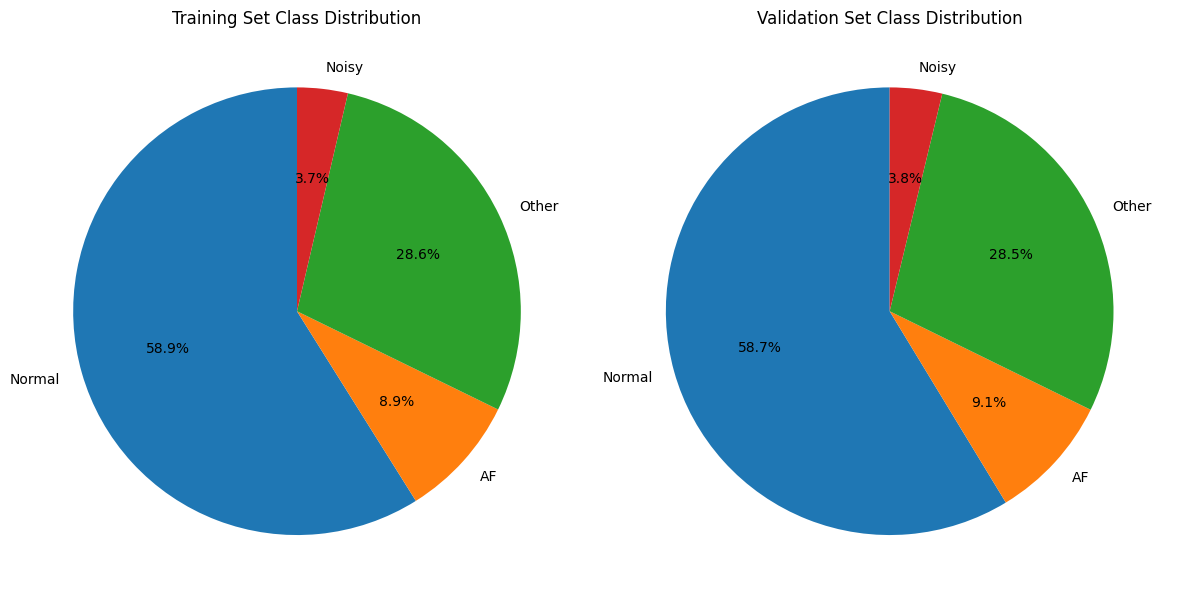

In [18]:
train_counts = train_df['label'].value_counts().sort_index()
val_counts = val_df['label'].value_counts().sort_index()

train_labels = [label_dict[i] for i in train_counts.index]
val_labels = [label_dict[i] for i in val_counts.index]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].pie(train_counts, labels=train_labels, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Training Set Class Distribution')

axs[1].pie(val_counts, labels=val_labels, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Validation Set Class Distribution')

plt.tight_layout()
plt.show()

Our strategy let us creating two sets (train and validation) that has similar class distribution. Also every classes in both sets include various number of samples that have different values for standard deviation of RR interval, also called Hearth Rate Variability.